# **INGEST**

In [ ]:
from google.colab import drive 
import numpy as np
import pandas as pd
import seaborn as sns
import re
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt


In [ ]:
drive.mount('/content/gdrive')
train=pd.read_csv('gdrive/My Drive/Data/train.csv')
test=pd.read_csv('gdrive/My Drive/Data/test.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **EDA**

Understand the data




In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


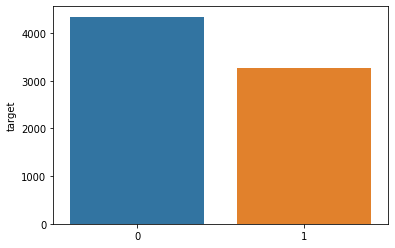

In [ ]:
class_dist = train.target.value_counts()
sns.barplot(class_dist.index,class_dist)

In [ ]:
train_x = train['text'].copy()
train_y = train['target'].copy()

Data cleaning

In [ ]:
stop = stopwords.words('english')

def clean(text):
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)    
    text = re.sub(r'#\w+', ' ', text)    
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.split()
    text = ' '.join([word for word in text if word not in stop])
    return text

In [ ]:
train_x_cleaned = train_x.apply(clean)
train_x_cleaned.head()

0                Our Deeds Reason May ALLAH Forgive us
1               Forest fire near La Ronge Sask. Canada
2    All residents asked 'shelter place' notified o...
3        , people receive evacuation orders California
4          Just got sent photo Ruby smoke pours school
Name: text, dtype: object

In [ ]:
max_len = max(train_x_cleaned.apply(len))
print('max length: {}'.format(max_len))

max length: 141


Tokenize

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x_cleaned)
vocab_size = len(tokenizer.word_index) + 1
x = tokenizer.texts_to_sequences(train_x_cleaned)
x = pad_sequences(x, max_len, padding='post')
y = train_y

In [ ]:
test_x = test['text'].copy()
test_x = test_x.apply(clean)
test_x = tokenizer.texts_to_sequences(test_x)
test_x = pad_sequences(test_x, max_len, padding='post')

# **MODEL & EVALUATE**

In [ ]:
epoch_size =10
batch_size = 32
embedding_dim = 16
optimizer = optimizers.Adam(lr=3e-4)

GRU 

In [ ]:
model = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    layers.Bidirectional(layers.GRU(256, return_sequences=True)),
    layers.GlobalMaxPool1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(2, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 141, 16)           223152    
_________________________________________________________________
bidirectional (Bidirectional (None, 141, 512)          420864    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 676,978
Trainable params: 676,978
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history1=model.fit(x, y, epochs=epoch_size, validation_split=0.1)

Epoch 1/10
215/215 [==============================] - 144s 654ms/step - loss: 0.6460 - accuracy: 0.6013 - val_loss: 0.4455 - val_accuracy: 0.7979
Epoch 2/10
215/215 [==============================] - 138s 644ms/step - loss: 0.3348 - accuracy: 0.8672 - val_loss: 0.4624 - val_accuracy: 0.7966
Epoch 3/10
215/215 [==============================] - 139s 648ms/step - loss: 0.2019 - accuracy: 0.9322 - val_loss: 0.5495 - val_accuracy: 0.7677
Epoch 4/10
215/215 [==============================] - 138s 641ms/step - loss: 0.1370 - accuracy: 0.9506 - val_loss: 0.5987 - val_accuracy: 0.7520
Epoch 5/10
215/215 [==============================] - 138s 643ms/step - loss: 0.1004 - accuracy: 0.9669 - val_loss: 0.8000 - val_accuracy: 0.7638
Epoch 6/10
215/215 [==============================] - 138s 641ms/step - loss: 0.0849 - accuracy: 0.9688 - val_loss: 0.7876 - val_accuracy: 0.7559
Epoch 7/10
215/215 [==============================] - 137s 639ms/step - loss: 0.0616 - accuracy: 0.9779 - val_loss: 1.2064 -

In [ ]:
test_pred1 = np.argmax(model.predict(test_x), axis=1)

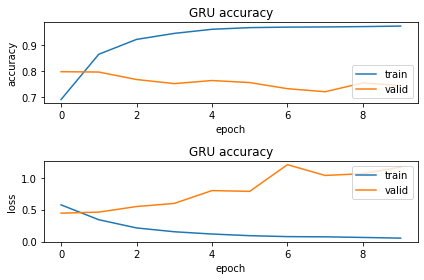

In [ ]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('GRU accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('GRU accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

plt.tight_layout()

LSTM

In [ ]:
model = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    layers.GlobalMaxPool1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(2, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 141, 16)           223152    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 141, 512)          559104    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 815,218
Trainable params: 815,218
Non-trainable params: 0
________________________________________________

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history2=model.fit(x, y, epochs=epoch_size, validation_split=0.1)

Epoch 1/10
215/215 [==============================] - 188s 859ms/step - loss: 0.6610 - accuracy: 0.5881 - val_loss: 0.4534 - val_accuracy: 0.7979
Epoch 2/10
215/215 [==============================] - 184s 858ms/step - loss: 0.3544 - accuracy: 0.8696 - val_loss: 0.4519 - val_accuracy: 0.7861
Epoch 3/10
215/215 [==============================] - 184s 855ms/step - loss: 0.2313 - accuracy: 0.9206 - val_loss: 0.5700 - val_accuracy: 0.7441
Epoch 4/10
215/215 [==============================] - 184s 857ms/step - loss: 0.1552 - accuracy: 0.9468 - val_loss: 0.6401 - val_accuracy: 0.7480
Epoch 5/10
215/215 [==============================] - 184s 856ms/step - loss: 0.1085 - accuracy: 0.9626 - val_loss: 0.6659 - val_accuracy: 0.7703
Epoch 6/10
215/215 [==============================] - 184s 854ms/step - loss: 0.0816 - accuracy: 0.9699 - val_loss: 1.1787 - val_accuracy: 0.7493
Epoch 7/10
215/215 [==============================] - 184s 856ms/step - loss: 0.0635 - accuracy: 0.9736 - val_loss: 0.8035 -

In [ ]:
test_pred2 = np.argmax(model.predict(test_x), axis=1)

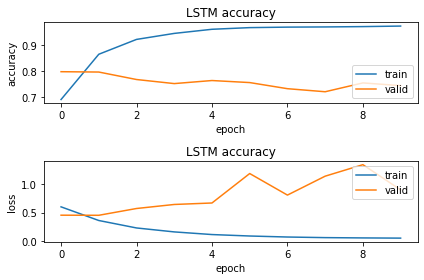

In [ ]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history2.history['accuracy'])
plt.plot(history2
         .history['val_accuracy'])
plt.title('LSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('LSTM accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

plt.tight_layout()

# **CONCLUSION**

We've created 2 RNN models: GRU and LSTM to identify disasters from Tweets. It seems like both of the models have achieved very high accuracy: around 97%. However, it seems like overfittings exist in both models from the lower accuracy for validation data set. I think early stop can be implemented in order to prevent the models from overfitting. 